In [38]:
import numpy as np
from numpy import sin as Sin
from numpy import cos as Cos

from scipy.optimize import minimize

import matplotlib.pyplot as plt
plt.style.use('paper.mplstyle')

from qiskit import Aer, execute, ClassicalRegister, QuantumRegister, QuantumCircuit, IBMQ

In [39]:
# IBMQ.enable_account('d3b7c023279124bef090f1c314bad06fa60a55a8f115891b5790d1cec64d9219056ee2d051f795b7d6f24373b145b5409be2ac00b8326141d723cebf3dfc2f58')
# IBMQ.save_account('d3b7c023279124bef090f1c314bad06fa60a55a8f115891b5790d1cec64d9219056ee2d051f795b7d6f24373b145b5409be2ac00b8326141d723cebf3dfc2f58')
provider = IBMQ.load_account()

/Users/jlazar/anaconda3/envs/qiskit/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-12-29 10:22:20,257: Credentials are already in use. The existing account in the session will be replaced.


# As a first step, we will discuss fitting the PMNS matrix via likelihood minimization

We need to fit the six parameters from the paper to match the measured values of the PMNS matrix, given by 

$$
\begin{pmatrix}
    0 & 0 & 0 & 0\\
    0 & 0 & 0 & 0\\
    0 & 0 & 0 & 0\\
    0 & 0 & 0 & 1\\
\end{pmatrix}
$$

To do this, we must first define a likelihood, which must have the proporty that it attains a glabal minimum when the parameters take on the correct value. One way we can achieve this is by using a method inspired by the least squared method. 

## Least squares likelihood

If we denote the measured PMNS matrix as $U_{\rm{PMNS}}$ and the matrix want to fit it to as $V$, one possible likelihood choice is given by:

$$
\mathcal{L} = \sum_{i,j=1}^{4}\left|U_{{\rm{PMNS}},\, ij}-V_{ij}\right|
$$

This is strictly non-negative since it is a sum of square real numbers, and it achives the global minimum of 0 exactly when each element of $V$ is equal to each member of $U_{\rm{PMNS}}$.

## Define functions for each element of the parametrized matrix
Don't do this by hand. Copy and paste this from me or use Mathematica

In [3]:
paper_PMNS_dagger_params = (-0.6031, 7.412-4*np.pi, 0.7966,  1.0139, 0.7053, -8.065+4*np.pi)
paper_PMNS_params        = (-0.7053, -1.3599,       0.7966, -1.0139, 0.6031,  2.0125)

In [4]:
def V11(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(beta/2.)*(Cos(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon + gamma)/2.) - Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.)) + \
           Sin(alpha/2.)*(-(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.)) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.))) + \
           Cos(beta/2.)*(-(Sin(alpha/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon + gamma)/2.) + Cos((epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) + \
           Cos(alpha/2.)*(Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Cos(zeta/2.) + Sin(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [5]:
def V21(alpha, beta, gamma, delta, epsilon, zeta):
    return Cos(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon + gamma)/2.) - Cos((alpha - epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
           Sin(beta/2.)*(-(Sin(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon + gamma)/2.) + Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.))) - \
           Cos(alpha/2.)*(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [6]:
def V31(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(alpha/2.)*(-(Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon - gamma)/2.) + Cos((epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) + \
           Cos(beta/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) - Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.))) + \
           Cos(alpha/2.)*(Cos(delta/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(beta/2.) + Cos(beta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
           Sin(delta/2.)*(-(Cos(beta/2.)*Cos(zeta/2.)*Sin((epsilon - gamma)/2.)) + Sin(beta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [7]:
def V41(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon - gamma)/2.) - Cos((alpha - epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
           Cos(beta/2.)*(Sin(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon - gamma)/2.) + Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
           Cos(alpha/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [8]:
def V12(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Cos(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon + gamma)/2.) + Cos((alpha - epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) + \
           Sin(beta/2.)*(Sin(alpha/2.)*(-(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon + gamma)/2.)) + Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.)) + \
           Cos(alpha/2.)*(-(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.)) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [9]:
def V22(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(beta/2.)*(-(Cos(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon + gamma)/2.) + Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.))) + \
           Sin(alpha/2.)*(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.))) + \
           Cos(beta/2.)*(Sin(alpha/2.)*(-(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon + gamma)/2.)) + Cos((epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
           Cos(alpha/2.)*(Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Cos(zeta/2.) - Sin(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [10]:
def V32(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon - gamma)/2.) + Cos((alpha - epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) + \
           Cos(beta/2.)*(Sin(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon - gamma)/2.) - Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
           Cos(alpha/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) - Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [11]:
def V42(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Sin(alpha/2.)*(Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon - gamma)/2.) - Cos((epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
           Cos(beta/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))) + \
           Cos(alpha/2.)*(Cos(delta/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(beta/2.) + Cos(beta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
           Sin(delta/2.)*(Cos(beta/2.)*Cos(zeta/2.)*Sin((epsilon - gamma)/2.) - Sin(beta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.))) 

In [12]:
def V13(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(alpha/2.)*(Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon + gamma)/2.) + Cos((epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
           Cos(beta/2.)*(-(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.)) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.))) - \
           Cos(alpha/2.)*(Cos(delta/2.)*(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(beta/2.) + Cos(beta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.)) + \
           Sin(delta/2.)*(-(Cos(beta/2.)*Cos(zeta/2.)*Sin((epsilon + gamma)/2.)) + Sin(beta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [13]:
def V23(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon + gamma)/2.) - Cos((alpha - epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) + \
           Cos(beta/2.)*(-(Sin(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon + gamma)/2.) + Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.))) - \
           Cos(alpha/2.)*(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [14]:
def V33(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Sin(beta/2.)*(Cos(alpha/2.)*(-(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon - gamma)/2.)) + Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
            Sin(alpha/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) - Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))) + \
            Cos(beta/2.)*(-(Sin(alpha/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon - gamma)/2.) + Cos((epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) + \
            Cos(alpha/2.)*(Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Cos(zeta/2.) + Sin(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [15]:
def V43(alpha, beta, gamma, delta, epsilon, zeta):
    return Cos(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon - gamma)/2.) - Cos((alpha - epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) - \
            Sin(beta/2.)*(Sin(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon - gamma)/2.) + Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
            Cos(alpha/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [16]:
def V14(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon + gamma)/2.) + Cos((alpha - epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
            Cos(beta/2.)*(Sin(alpha/2.)*(-(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon + gamma)/2.)) + Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.)) +\
            Cos(alpha/2.)*(-(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.)) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [17]:
def V24(alpha, beta, gamma, delta, epsilon, zeta):
    return Sin(alpha/2.)*(Sin(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon + gamma)/2.) - Cos((epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
            Cos(beta/2.)*(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.))) - \
            Cos(alpha/2.)*(Cos(delta/2.)*(Cos((epsilon + gamma)/2.)*Cos(zeta/2.)*Sin(beta/2.) + Cos(beta/2.)*Cos((epsilon - gamma)/2.)*Sin(zeta/2.)) + \
            Sin(delta/2.)*(Cos(beta/2.)*Cos(zeta/2.)*Sin((epsilon + gamma)/2.) - Sin(beta/2.)*Sin((epsilon - gamma)/2.)*Sin(zeta/2.)))

In [18]:
def V34(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Cos(beta/2.)*(Cos(delta/2.)*Cos(zeta/2.)*Sin((alpha + epsilon - gamma)/2.) + Cos((alpha - epsilon - gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.))) - \
            Sin(beta/2.)*(Sin(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon - gamma)/2.) - Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) + \
            Cos(alpha/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) - Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

In [19]:
def V44(alpha, beta, gamma, delta, epsilon, zeta):
    return -(Sin(beta/2.)*(Cos(alpha/2.)*(Cos(zeta/2.)*Sin(delta/2.)*Sin((epsilon - gamma)/2.) + Cos(delta/2.)*Cos((epsilon + gamma)/2.)*Sin(zeta/2.)) - \
            Sin(alpha/2.)*(Cos((epsilon - gamma)/2.)*Cos(zeta/2.)*Sin(delta/2.) + Cos(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))) + \
            Cos(beta/2.)*(Sin(alpha/2.)*(-(Cos(delta/2.)*Cos(zeta/2.)*Sin((epsilon - gamma)/2.)) + Cos((epsilon + gamma)/2.)*Sin(delta/2.)*Sin(zeta/2.)) + \
            Cos(alpha/2.)*(Cos(delta/2.)*Cos((epsilon - gamma)/2.)*Cos(zeta/2.) - Sin(delta/2.)*Sin((epsilon + gamma)/2.)*Sin(zeta/2.)))

## Now we gather up all these functions and put them in a nice matrix form

In [20]:
def V(params):
    return np.array([
                     [V11(*params), V12(*params), V13(*params), V14(*params)],
                     [V21(*params), V22(*params), V23(*params), V24(*params)],
                     [V31(*params), V32(*params), V33(*params), V34(*params)],
                     [V41(*params), V42(*params), V43(*params), V44(*params)],
                    ]
                   )

Define the measured PMNS matrix

In [21]:
U_PMNS = np.array([
                   [0.821327, 0.149719, 0.55046, 0.0000235964],
                   [0.305724, 0.699143, -0.646322, 0.000158188],
                   [-0.481617, 0.699131, 0.528452, 0.000103754],
                   [-0.0000177728, -0.000186666, 0.000034423, 1.]
                  ]
                 )

## Define likelihood described above

In [22]:
def matrix_likelihood(params, target_matrix):
    # make a box
    if np.any([p>2*np.pi for p in params]):
        value = np.inf
    elif np.any([p<-2*np.pi for p in params]):
        value = np.inf
    else:
        mat   = V(tuple(params))
        value = np.sum([np.abs(np.abs(mat[i,j]-target_matrix[i,j])) for i in range(4)
                                                                    for j in range(4)]
                 )
    return value

We must provide a starting point in the paramter space to the minimizer. In general, we would like this to be reasonably close to the best fit point. In order to find a decent starting position, we can pick $n$ positions randomly, and then pick the one that gives us the minimum likelihood value.

In [23]:
# randomly select set of params
n_guesses                   = 10000
first_guesses               = [tuple(2*np.pi*(2*np.random.rand((6))-1)) for i in range(n_guesses)]
llhs                        = [matrix_likelihood(guess, U_PMNS) for guess in first_guesses] # evaluate likelihood for each guess
sorted_llhs, sorted_guesses = zip(*sorted(zip(llhs, first_guesses)))
best_guess                  = np.array(sorted_guesses[0]) # pick the guess that gave the lowest likelihood value
result                      = minimize(matrix_likelihood, best_guess, method='L-BFGS-B', args=U_PMNS) # run the minimizer starting from the best guess
print('Relative error for each entry')
print((V(result.x)-U_PMNS)/U_PMNS)
print(r'The best fit parameters are $\alpha$=%s, $\beta$=%s, $\gamma$=%s, $\delta$=%s, $\epsilon$=%s, $\zeta$=%s' % tuple(result.x))

Relative error for each entry
[[ 1.80583629e-01  3.26263902e-01 -9.77065699e-01 -6.02423296e+03]
 [-1.47732849e+00  1.26525261e-01 -7.72254826e-02  3.26422200e+02]
 [-7.28509852e-01 -1.65763496e-01  5.17042861e-01 -5.87894457e+01]
 [-8.23114245e+03  4.81809037e+01  1.10084524e+03 -1.15257063e-02]]
The best fit parameters are $\alpha$=-3.282193910785553, $\beta$=1.9242505938027663, $\gamma$=0.5341464356469316, $\delta$=5.499844403171498, $\epsilon$=3.1131369964310607, $\zeta$=4.243849072496942


/Users/jlazar/anaconda3/envs/qiskit/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


# Error evaluation

Easy peasy. Now let's move on to thinking about choosing a good basis. This comes down to a choice of basis vectors. Before we were using the convention:

\begin{align}
\left|\nu_{1}\right> = \begin{pmatrix}1\\0\\0\\0\end{pmatrix} \qquad \left|\nu_{2}\right> = \begin{pmatrix}0\\1\\0\\0\end{pmatrix} \qquad \left|\nu_{3}\right> = \begin{pmatrix}0\\0\\1\\0\end{pmatrix},
\end{align}

but this was an arbitrary choice, and infinitely many other choices are available, some of which may result in fewer errors.

As a reminder, errors come from an accidental bit flip, which can happen with some probability which we measure empirically. We will label the probability of an accidental bit flip in the first and second qubits $p_{1}$ and $p_{2}$ respectively. For now, I will just take the numbers given in Carlos' paper and we can make our own measurement independently, \textit{i.e.} we will set $p_{1}$=0.13 and $p_{1}$=0.03.

Our strategy will be:

1) Pick a random set of basis vectors.

2) Run our quantum code using the quantum simulator.

3) Probabilistically flip some of the bits from the results according to our $p$s


4) Repeat many times, assessing the level of error for each, and find which set of basis vectors give the smallest error

## 1) Basis vectors

The two rules of basis vectors are 1) they must be orthogonal. 2) They must have modulus of 1. Since these are very common conditions in physics, we say that a set of vectors that meets both is \textit{orthonormal}. Given an arbitrary set of vectors, we can create a set of vectors that abide by these conditions using the Gram-Schmidt procedure.

In [24]:
def norm(vector):
    vector= np.array(vector)
    return np.sqrt(np.sum(vector*vector))

def gram_schmidt(vectors):
    assert(vectors.shape[0]==vectors.shape[1])
    result = np.zeros(vectors.shape)
    for i, vec0 in enumerate(vectors):
        tmp = vec0
        for vec in result[:i]:
            tmp = tmp-np.dot(vec, vec0)*vec
        result[i] = tmp/norm(tmp)
    return result

In [25]:
gs_vectors = np.zeros((4,4))
vectors           = (np.random.rand(9)-0.5).reshape(3,3) # Generate some random numbers
gs_vectors[:3,:3] = gram_schmidt(vectors)
gs_vectors[3,3]   = 1
U_PMNS_prime = np.matmul(gs_vectors, U_PMNS.T)
print(U_PMNS_prime)

[[-8.46085119e-03  2.19443392e-01 -9.75588733e-01  6.67068340e-05]
 [ 2.93137744e-02 -9.75149859e-01 -2.19599464e-01  1.76349522e-04]
 [ 9.99534466e-01  3.04561377e-02 -1.81803196e-03 -2.82144511e-05]
 [ 2.35964000e-05  1.58188000e-04  1.03754000e-04  1.00000000e+00]]


## 2) Run on a quantum simulator

Now we have a new basis selected, which ultimately gives us a different representation on the PMNS matrix. Thus we must fit a new set of parameters that we can enter into our simulator

In [26]:
# randomly select set of params
n_guesses                   = 10000
first_guesses               = [tuple(2*np.pi*(2*np.random.rand((6))-1)) for i in range(n_guesses)]
llhs                        = [matrix_likelihood(guess, U_PMNS_prime) for guess in first_guesses] # evaluate likelihood for each guess
sorted_llhs, sorted_guesses = zip(*sorted(zip(llhs, first_guesses)))
best_guess                  = np.array(sorted_guesses[0]) # pick the guess that gave the lowest likelihood value
PMNS_fit                    = minimize(matrix_likelihood, best_guess, method='L-BFGS-B', tol=1e-15, args=U_PMNS_prime) # run the minimizer starting from the best guess
PMNS_params                 = PMNS_fit.x
PMNS_dagger_params          = (-PMNS_params[4],-PMNS_params[5],-PMNS_params[2],-PMNS_params[3],-PMNS_params[0],-PMNS_params[1],)
print(r'The best fit parameters are $\alpha$=%s, $\beta$=%s, $\gamma$=%s, $\delta$=%s, $\epsilon$=%s, $\zeta$=%s' % tuple(PMNS_params))

# print(np.log10(np.abs((V(PMNS_params)-U_PMNS)/U_PMNS)))
print(np.log10(np.abs((V(PMNS_params)-U_PMNS_prime)/U_PMNS_prime)))

# print("Let's check a couple things. First, let's make sure that we have an orthoginal matrix. These should both give the identity matrix")
# print("np.matmul(V(PMNS_params), V(PMNS_params).T)==")
# print(np.matmul(V(PMNS_params), V(PMNS_params).T))

# print("np.matmul(V(PMNS_params), V(PMNS_dagger_params))==")
# print(np.matmul(V(PMNS_params), V(PMNS_dagger_params)))

The best fit parameters are $\alpha$=-4.828456119325477, $\beta$=-5.4526833740459795, $\gamma$=6.162345451316822, $\delta$=-4.7999586791740265, $\epsilon$=-1.5998933115306389, $\zeta$=1.0063031915580345
[[ 0.9979423  -0.11171502 -1.71651599  2.37407291]
 [ 0.65620063  0.30156682  0.1069404   2.99189628]
 [-2.03103719  0.38697692  1.66843486  3.04808898]
 [ 2.70811682  3.04564884  1.88626476 -1.80427374]]


We have a set of parameters for our propagation, so now let's propagate

In [27]:
from three_neutrino import ThreeNuOscillator

In [28]:
loee = np.linspace(0, 1200, 21)
n = 10000
sim_results = np.zeros((4,len(loee)))
for i, LE in enumerate(loee):
    tno = ThreeNuOscillator('numu')
    tno.apply_rotation(param=paper_PMNS_params)
    tno.propoagate(LE)
    tno.apply_rotation(param=paper_PMNS_dagger_params)
    tno.measure()
    job = execute(tno.qc, Aer.get_backend('qasm_simulator'), shots=n)
    counts = job.result().get_counts(tno.qc)
    for j, (key, val) in enumerate(sorted(counts.items())):
        sim_results[j, i] = float(val)/n



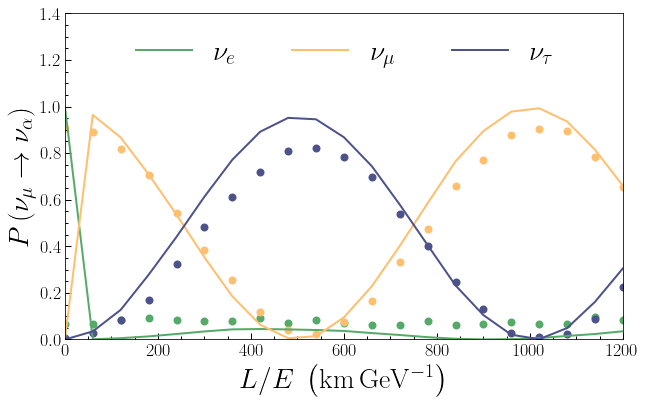

In [29]:
labels = [r'$\nu_{e}$', r'$\nu_{\mu}$', r'$\nu_{\tau}$', ]
cs     = ['#56aa69',     '#ffbf6e',      '#4d528a']
qc_results = np.load('three_neutrino_qc.npy') # Load results from actual quantum computer
plt.figure(figsize=[10,6])
for i, (c, lab) in enumerate(zip(cs, labels)):
    plt.scatter(loee, qc_results[i], color=c)
    plt.plot(loee, sim_results[i], label=lab, color=c)
plt.legend(fontsize=28, ncol=3,loc='upper center', frameon=False)
plt.xlim(0, 1200)
plt.ylim(0, 1.4)
plt.xlabel(r'$L/E~\left(\rm{km}\,\rm{GeV}^{-1}\right)$')
plt.ylabel(r'$P\left(\nu_{\mu}\rightarrow\nu_{\alpha}\right)$')
plt.show()

## 3) Probabilistically flip some bits

Let's look at how this would look for a single instance of counts

In [40]:
p0 = 0.05
p1 = 0.03

sim_results_error = np.full((2, n), np.nan) # premake array which we will fill with our results
container = np.full((2, n), np.nan) # premake array which we will fill with our results
start = 0
for key, val in counts.items():
    for i in range(val):
        container[:,i+start] = [x for x in str(key)]
    start += val

rand_ns1 = np.random.rand(n) # Make some random numbers between 0 and 1
rand_ns2 = np.random.rand(n) # Make some random numbers between 0 and 1
sim_results_error[0] = np.where(rand_ns1>p0, container[0], 1-container[0])
sim_results_error[1] = np.where(rand_ns2>p1, container[1], 1-container[1])
counts_error = {'11':0, '00':0, '01':0, '10':0}
for entry in sim_results_error.T: # gather things back into a dictionary
    key = str(int(entry[0]))+str(int(entry[1]))
    counts_error[key] += 1
print(counts)
print(counts_error)

ValueError: cannot convert float NaN to integer

Now let's make this into a function for easy use

In [31]:
def make_counts_error(counts, p1=0.05, p2=0.03):
    sim_results_error = np.full((2, n), np.nan) # premake array which we will fill with our results
    container = np.full((2, n), np.nan) # premake array which we will fill with our results
    start = 0
    for key, val in counts.items():
        for i in range(val):
            container[:,i+start] = [x for x in str(key)]
        start += val

    rand_ns1 = np.random.rand(n) # Make some random numbers between 0 and 1
    rand_ns2 = np.random.rand(n) # Make some random numbers between 0 and 1
    sim_results_error[0] = np.where(rand_ns1>p1, container[0], 1-container[0])
    sim_results_error[1] = np.where(rand_ns2>p2, container[1], 1-container[1])
    counts_error = {'11':0, '00':0, '01':0, '10':0}
    for entry in sim_results_error.T: # gather things back into a dictionary
        key = str(int(entry[0]))+str(int(entry[1]))
        counts_error[key] += 1
    return counts_error

Now we can rerun the QC simulator, adding in errors by hand at every step

In [32]:
loee = np.linspace(0, 1200, 21)
shots = 10000
sim_results = np.zeros((4,len(loee)))
sim_results_error = np.zeros((4,len(loee)))
for i, LE in enumerate(loee):
    tno = ThreeNuOscillator('numu')
    tno.apply_rotation(param=paper_PMNS_params)
    tno.propoagate(LE)
    tno.apply_rotation(param=paper_PMNS_dagger_params)
    tno.measure()
    job = execute(tno.qc, Aer.get_backend('qasm_simulator'), shots=shots)
    counts = job.result().get_counts(tno.qc)
    counts_error = make_counts_error(counts, p1=0.13, p2=0.03)
    for j, (key, val) in enumerate(sorted(counts.items())):
        sim_results[j, i] = float(val)/n
    for j, (key, val) in enumerate(sorted(counts_error.items())):
        sim_results_error[j, i] = float(val)/n

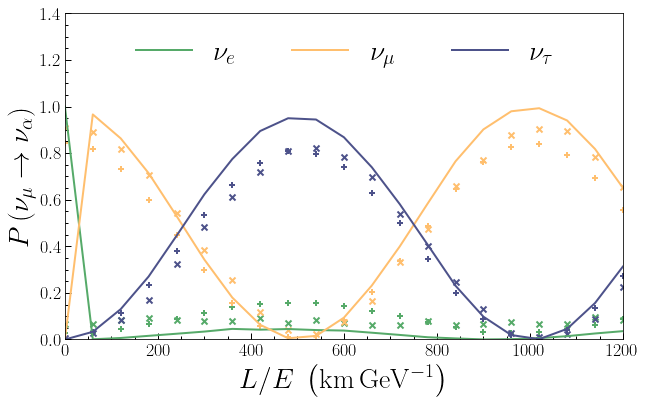

In [33]:
labels = [r'$\nu_{e}$', r'$\nu_{\mu}$', r'$\nu_{\tau}$', ]
cs     = ['#56aa69',     '#ffbf6e',      '#4d528a']
qc_results = np.load('three_neutrino_qc.npy') # Load results from actual quantum computer
plt.figure(figsize=[10,6])
for i, (c, lab) in enumerate(zip(cs, labels)):
    plt.scatter(loee, qc_results[i], color=c, marker='x')
    plt.scatter(loee, sim_results_error[i], color=c, marker='+')
    plt.plot(loee, sim_results[i], label=lab, color=c)
plt.legend(fontsize=28, ncol=3,loc='upper center', frameon=False)
plt.xlim(0, 1200)
plt.ylim(0, 1.4)
plt.xlabel(r'$L/E~\left(\rm{km}\,\rm{GeV}^{-1}\right)$')
plt.ylabel(r'$P\left(\nu_{\mu}\rightarrow\nu_{\alpha}\right)$')
plt.show()

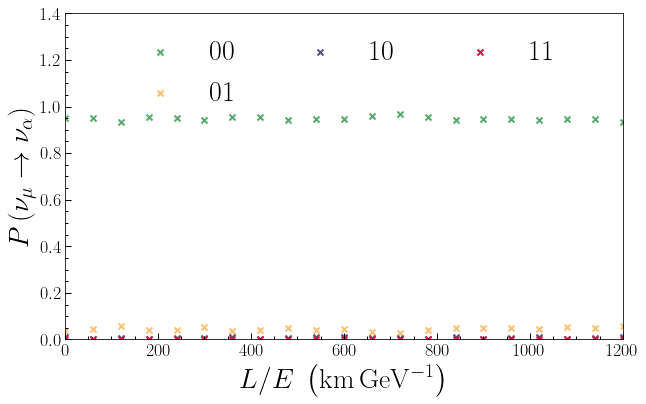

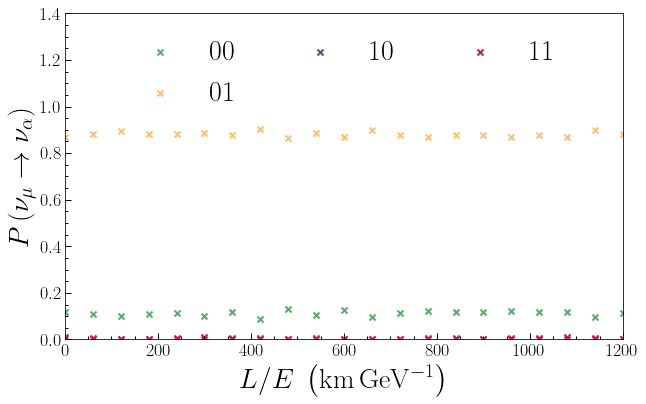

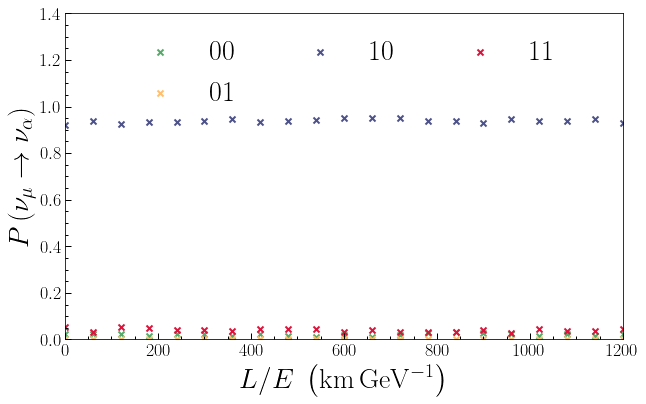

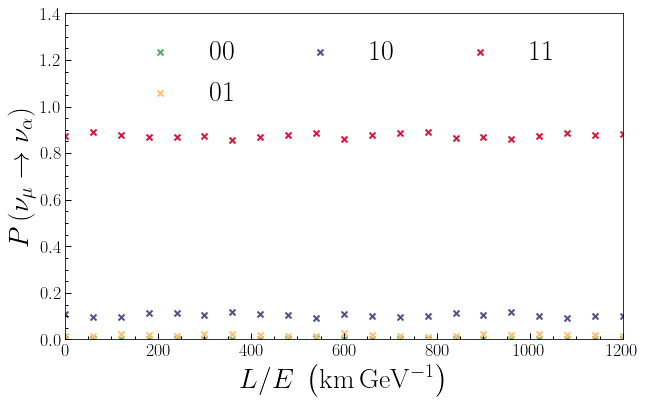

In [37]:
counts = {'00':1, '10':1, '01':1, '11':1}
labels = sorted(counts.keys())
cs     = ['#56aa69',     '#ffbf6e',      '#4d528a', 'crimson']
for init_state in ['nue', 'numu', 'nutau', 'nus']:
    qc_results = np.load('error_check_%s.npy' % init_state) # Load results from actual quantum computer
    plt.figure(figsize=[10,6])
    for i, (c, lab) in enumerate(zip(cs, labels)):
        plt.scatter(loee, qc_results[i], color=c, marker='x', label=lab)
    plt.legend(fontsize=28, ncol=3,loc='upper center', frameon=False)
    plt.xlim(0, 1200)
    plt.ylim(0, 1.4)
    plt.xlabel(r'$L/E~\left(\rm{km}\,\rm{GeV}^{-1}\right)$')
    plt.ylabel(r'$P\left(\nu_{\mu}\rightarrow\nu_{\alpha}\right)$')
    plt.show()

In [50]:
out_matrix = np.full((4,4), np.nan)
for i, init_state in enumerate(['nue', 'numu', 'nutau', 'nus']):
    qc_results = np.load('error_check_%s.npy' % init_state) # Load results from actual quantum computer
    out_matrix[:,i] = np.mean(qc_results, axis=1)
print(out_matrix)
print(np.sum(out_matrix, axis=0))
print(np.sum(out_matrix), axis=1)

[[9.48428199e-01 1.12490699e-01 2.05543155e-02 1.86011905e-03]
 [4.47358631e-02 8.80859375e-01 5.11532738e-04 1.87406994e-02]
 [6.55691964e-03 9.76562500e-04 9.38941592e-01 1.04771205e-01]
 [2.79017857e-04 5.67336310e-03 3.99925595e-02 8.74627976e-01]]


TypeError: 'axis' is an invalid keyword argument for print()